# Capstone Project - - The Prediction of potential car collision severity

### QIN LIN

## Introduction: Business Problem

In this project we will find the optimal model to predict the severity of car accident based on its physical surroundings. The report is specially targeted to stakeholders interested in **giving more effective and accurate warnings to drivers on the road**.

We need to ensure the prediction generalized and can be **applied to different regions**, not only in Seattle where the data was recorded.

So we will look into the detailed geographic locations but focus more on the junction features or other general factors. 

## Data

In [257]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Based on our understanding of the business problem, we select factors which may influence our model and prediction of severity (SEVERITYCODE).

* The address type of car accident (ADDRTYPE)
* The catetory of junction where accident takes place (JUNCTIONTYPE)
* The weather condition (WEATHER)
* The road condition (ROADCOND)
* The light condition (LIGHTCOND)
* Whether speeding involved (SPEEDING)

Let's **load CSV file** from the link and do some **basic exploration**.

In [258]:
import pandas as pd
cc_df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [259]:
cc_df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [260]:
cc_df.shape

(194673, 38)

In [261]:
cc_df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

## Data visualization and pre-processing

### 1. The address type of car accident (ADDRTYPE)

In [262]:
cc_df['ADDRTYPE'].value_counts()

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

126926 car accidents take place in the block, 65070 in the intersection and 751 in the alley

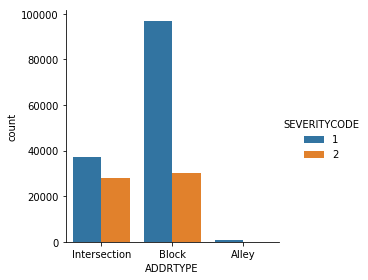

In [263]:
import seaborn as sns

sns.catplot(x="ADDRTYPE", hue="SEVERITYCODE",
            data=cc_df, kind="count",
            height=4, aspect=1);


### 2. The catetory of junction where accident takes place (JUNCTIONTYPE)

In [264]:
cc_df['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

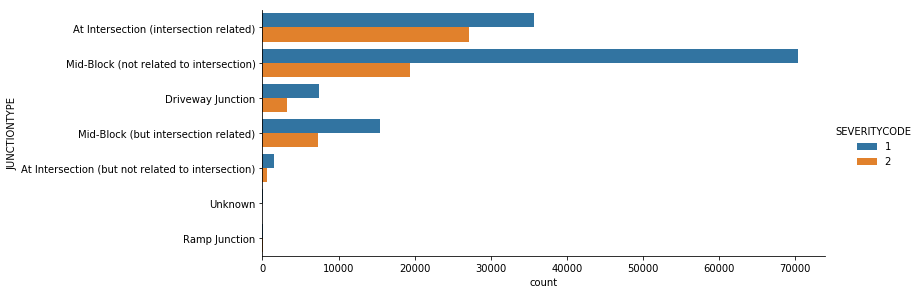

In [265]:
sns.catplot(y="JUNCTIONTYPE", hue="SEVERITYCODE",
            data=cc_df, kind="count",
            height=4, aspect=3);

### Relationship between JUNCTIONTYPE and ADDRTYPE

It seems JUNCTIONTYPE is the sub-category of ADDRTYPE, so let's explore the relationship between them.

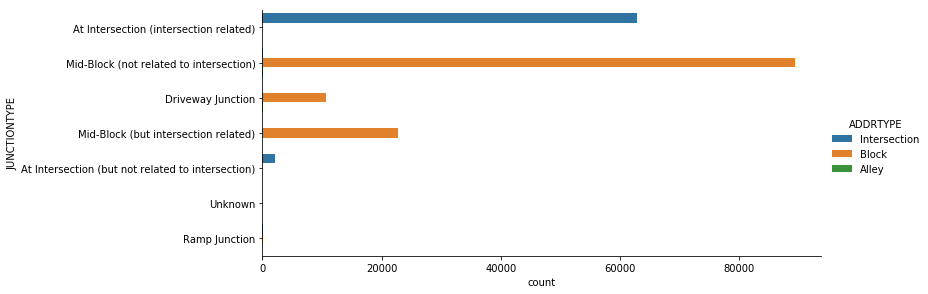

In [266]:
sns.catplot(y="JUNCTIONTYPE", hue="ADDRTYPE",
            data=cc_df, kind="count",
            height=4, aspect=3);

JUNCTIONTYPE belong to one category of ADDRTYPE.So, we will **drop JUNCTIONTYPE** to simplify the model.

Then encode ADDRTYPE as

* Block = 0
* Intersection = 1
* Alley = 2

In [267]:
cc_df['ADDRTYPE'].head()

0    Intersection
1           Block
2           Block
3           Block
4    Intersection
Name: ADDRTYPE, dtype: object

In [268]:
cc_df['ADDRTYPE'].replace({'Block': 0, 'Intersection': 1, 'Alley': 2}, inplace = True)
cc_df['ADDRTYPE'].head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: ADDRTYPE, dtype: float64

### 3. The weather condition (WEATHER)

In [269]:
cc_df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.732143
                          2               0.267857
Clear                     1               0.677509
                          2               0.322491
Fog/Smog/Smoke            1               0.671353
                          2               0.328647
Other                     1               0.860577
                          2               0.139423
Overcast                  1               0.684456
                          2               0.315544
Partly Cloudy             2               0.600000
                          1               0.400000
Raining                   1               0.662815
                          2               0.337185
Severe Crosswind          1               0.720000
                          2               0.280000
Sleet/Hail/Freezing Rain  1               0.752212
                          2               0.247788
Snowing                   1               0

There some similarity between weather, so we encode them as follows.

* Clear = 0 
* Overcast = 1; Partly Cloudy = 1
* Fog/Smog/Smoke = 2; Blowing Sand/Dirt = 2; Severe Crosswind = 2
* Raining = 3; Sleet/Hail/Freezing Rain = 3; Snowing = 3                   
* Unknown = 999; Other = 999

In [270]:
cc_df['WEATHER'].head()

0    Overcast
1     Raining
2    Overcast
3       Clear
4     Raining
Name: WEATHER, dtype: object

In [271]:
cc_df['WEATHER'].replace({'Clear': 0 , 'Overcast': 1, 'Partly Cloudy': 1, 
                          'Fog/Smog/Smoke': 2, 'Blowing Sand/Dirt': 2, 'Severe Crosswind': 2, 
                          'Raining': 3, 'Sleet/Hail/Freezing Rain': 3, 'Snowing': 3, 
                          'Unknown': 999, 'Other': 999}, inplace = True)
cc_df['WEATHER'].head()

0    1.0
1    3.0
2    1.0
3    0.0
4    3.0
Name: WEATHER, dtype: float64

### 4. The road condition (ROADCOND)

In [272]:
cc_df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             1               0.678227
                2               0.321773
Ice             1               0.774194
                2               0.225806
Oil             1               0.625000
                2               0.375000
Other           1               0.674242
                2               0.325758
Sand/Mud/Dirt   1               0.693333
                2               0.306667
Snow/Slush      1               0.833665
                2               0.166335
Standing Water  1               0.739130
                2               0.260870
Unknown         1               0.950325
                2               0.049675
Wet             1               0.668134
                2               0.331866
Name: SEVERITYCODE, dtype: float64

In [273]:
cc_df['ROADCOND'].head()

0    Wet
1    Wet
2    Dry
3    Dry
4    Wet
Name: ROADCOND, dtype: object

There some similarity between road conditions, so we encode them as follows.

* Dry = 0
* Sand/Mud/Dirt = 1; Standing Water = 1; Wet = 1
* Oil = 2; Ice = 2; Snow/Slush = 2; 
* Unknown = 999; Other = 999

In [274]:
cc_df['ROADCOND'].replace({'Dry': 0 , 'Sand/Mud/Dirt': 1, 'Standing Water': 1, 'Wet': 1, 
                           'Oil': 2, 'Ice': 2, 'Snow/Slush': 2, 
                           'Unknown': 999, 'Other': 999}, inplace = True)
cc_df['ROADCOND'].head()

0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: ROADCOND, dtype: float64

### 5. The light condition (LIGHTCOND)

In [275]:
cc_df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   1               0.782694
                          2               0.217306
Dark - Street Lights Off  1               0.736447
                          2               0.263553
Dark - Street Lights On   1               0.701589
                          2               0.298411
Dark - Unknown Lighting   1               0.636364
                          2               0.363636
Dawn                      1               0.670663
                          2               0.329337
Daylight                  1               0.668116
                          2               0.331884
Dusk                      1               0.670620
                          2               0.329380
Other                     1               0.778723
                          2               0.221277
Unknown                   1               0.955095
                          2               0.044905
Name: SEVERITYCODE, dtype: float64

In [276]:
cc_df['LIGHTCOND'].head()

0                   Daylight
1    Dark - Street Lights On
2                   Daylight
3                   Daylight
4                   Daylight
Name: LIGHTCOND, dtype: object

There some similarity between light conditions, so we encode them as follows.

* Daylight = 0                                    
* Dusk = 1; Dawn = 1; Dark - Street Lights On = 1
* Dark - No Street Lights = 2; Dark - Street Lights Off = 2
* Unknown = 999; Other = 999, Dark - Unknown Lighting = 999

In [277]:
cc_df['LIGHTCOND'].replace({'Daylight': 0 , 'Dusk': 1, 'Dawn': 1, 'Dark - Street Lights On': 1, 
                           'Dark - No Street Lights': 2, 'Dark - Street Lights Off': 2, 
                           'Unknown': 999, 'Other': 999, 'Dark - Unknown Lighting': 999}, inplace = True)
cc_df['LIGHTCOND'].head()

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: LIGHTCOND, dtype: float64

### 6. Whether speeding involved (SPEEDING)

In [278]:
cc_df['SPEEDING'].value_counts()

Y    9333
Name: SPEEDING, dtype: int64

We assume nan value in SPEEDING means No speeding problems involved. let's replace nan with N.

In [279]:
# Replace nan with N
cc_df['SPEEDING'] = cc_df['SPEEDING'].fillna('N')
cc_df['SPEEDING'].head()

0    N
1    N
2    N
3    N
4    N
Name: SPEEDING, dtype: object

In [280]:
cc_df['SPEEDING'].replace({'N': 0 , 'Y': 1}, inplace = True)
cc_df['SPEEDING'].head()

0    0
1    0
2    0
3    0
4    0
Name: SPEEDING, dtype: int64

# Feature Selection
### Correlation

In [281]:
# Compute correlation between variables and further drop those with low correlation
final_df = cc_df[['ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'SEVERITYCODE']]
final_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,ADDRTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,SEVERITYCODE
ADDRTYPE,1.000000,0.037665,0.061234,0.078449,0.058618,0.172032
WEATHER,0.037665,1.000000,0.639360,0.339952,-0.056737,0.055049
ROADCOND,0.061234,0.639360,1.000000,0.370477,-0.052357,0.082918
LIGHTCOND,0.078449,0.339952,0.370477,1.000000,0.014951,0.128798
SPEEDING,0.058618,-0.056737,-0.052357,0.014951,1.000000,-0.038938
SEVERITYCODE,0.172032,0.055049,0.082918,0.128798,-0.038938,1.000000


We drop the two variables with smallest correlations **WEATHER** (0.055) and **SPEEDING** (-0.0389)

In [294]:
# Complete feature selection
final_df = cc_df[['ADDRTYPE', 'ROADCOND', 'LIGHTCOND', 'SEVERITYCODE']]
final_df = final_df.dropna()

# My system cannot handle the original number of data, it's too large, so choose to sample
sample_df = final_df.sample(n=30000,replace = False, axis = 0) 
sample_df.head()

,ADDRTYPE,ROADCOND,LIGHTCOND,SEVERITYCODE
39317,0.0,1.0,0.0,2
127463,0.0,0.0,0.0,2
48040,0.0,0.0,1.0,1
5526,0.0,0.0,0.0,1
159838,0.0,0.0,1.0,2


In [295]:
X = sample_df[['ADDRTYPE', 'ROADCOND', 'LIGHTCOND']]
X.head()

,ADDRTYPE,ROADCOND,LIGHTCOND
39317,0.0,1.0,0.0
127463,0.0,0.0,0.0
48040,0.0,0.0,1.0
5526,0.0,0.0,0.0
159838,0.0,0.0,1.0


In [296]:
y = sample_df[[ 'SEVERITYCODE']].values

## Normalize Data

Data Standardization give data zero mean and unit variance

In [297]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:2]

array([[-0.71622091, -0.28406232, -0.27419961],
       [-0.71622091, -0.28784158, -0.27419961]])

## Classification

In the report, we will use the training set to build an accurate model. Then use the test set to report the accuracy of the model.

We will use the following algorithm:
    
* K Nearest Neighbor(KNN)
* Decision Tree
* Support Vector Machine
* Logistic Regression

## K Nearest Neighbor(KNN)

In [298]:
# 30% test data, 70% train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/_

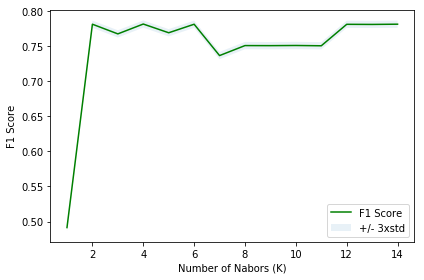

In [299]:
# Find k with the highest F1 score
# Use F1 score to find best k due to imbalanced data
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.f1_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

# plot accuracy of each k
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('F1 Score', '+/- 3xstd'))
plt.ylabel('F1 Score')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [300]:
# Evaluation of K Nearest Neighbor with the best accuracy
print( "The best f1 score is with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
from sklearn.metrics import classification_report, confusion_matrix
neigh = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_train,y_train)
knn_yhat=neigh.predict(X_test)
print(confusion_matrix(y_test, knn_yhat))
print(classification_report(y_test, knn_yhat))

The best f1 score is with 0.7812177502579979 with k= 4


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[[5299  840]
 [2128  733]]
              precision    recall  f1-score   support

           1       0.71      0.86      0.78      6139
           2       0.47      0.26      0.33      2861

   micro avg       0.67      0.67      0.67      9000
   macro avg       0.59      0.56      0.56      9000
weighted avg       0.63      0.67      0.64      9000



## Decision Tree

In [301]:
# 30% test data, 70% train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

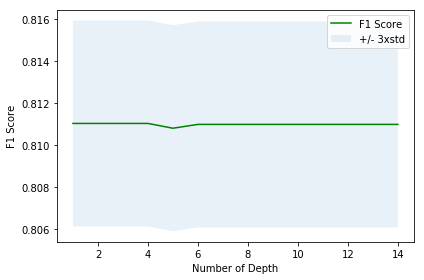

In [302]:
# Find depth of DecisionTree with the highest F1 score
# Use F1 score to find best depth due to imbalanced data, we want to detect 'Collection' i.e. 1
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
depth = 15
mean_acc = np.zeros((depth-1))
std_acc = np.zeros((depth-1))
for n in range(1,depth):
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    tree_yhat = loanTree.predict(X_test)
    mean_acc[n-1] = metrics.f1_score(y_test, tree_yhat)
    std_acc[n-1]=np.std(tree_yhat==y_test)/np.sqrt(tree_yhat.shape[0])

# plot accuracy of each depth
plt.plot(range(1,depth),mean_acc,'g')
plt.fill_between(range(1,depth),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('F1 Score', '+/- 3xstd'))
plt.ylabel('F1 Score')
plt.xlabel('Number of Depth')
plt.tight_layout()
plt.show()

In [303]:
# Evaluation of decision tree with depth 
print( "The best f1 score is with", mean_acc.max(), "with depth=", mean_acc.argmax()+1)
from sklearn.metrics import classification_report, confusion_matrix
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = mean_acc.argmax()+1).fit(X_train,y_train)
tree_yhat = loanTree.predict(X_test)
print(confusion_matrix(y_test, tree_yhat))
print(classification_report(y_test, tree_yhat))

The best f1 score is with 0.8110179007860493 with depth= 1
[[6139    0]
 [2861    0]]
              precision    recall  f1-score   support

           1       0.68      1.00      0.81      6139
           2       0.00      0.00      0.00      2861

   micro avg       0.68      0.68      0.68      9000
   macro avg       0.34      0.50      0.41      9000
weighted avg       0.47      0.68      0.55      9000



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Support Vector Machine

In [304]:
# 30% test data, 70% train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

In [305]:
# try different types of kernel
from sklearn import svm
from sklearn import metrics
# Radial basis function
rbf_svm = svm.SVC(kernel='rbf')
rbf_svm.fit(X_train, y_train)
rbf_yhat = rbf_svm.predict(X_test)
print("Accuracy of 'rbf' is: ", metrics.accuracy_score(y_test, rbf_yhat))
# Polynomial
poly_svm = svm.SVC(kernel='poly', degree=8)
poly_svm.fit(X_train, y_train)
poly_yhat = poly_svm.predict(X_test)
print("Accuracy of 'poly' is: ", metrics.accuracy_score(y_test, poly_yhat))
# Sigmoid
sig_svm = svm.SVC(kernel='sigmoid')
sig_svm.fit(X_train, y_train)
sig_yhat = sig_svm.predict(X_test)
print("Accuracy of 'sigmoid' is: ", metrics.accuracy_score(y_test, sig_yhat))
# Linear
lin_svm = svm.SVC(kernel='linear')
lin_svm.fit(X_train, y_train)
lin_yhat = lin_svm.predict(X_test)
print("Accuracy of 'linear' is: ", metrics.accuracy_score(y_test, lin_yhat))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of 'rbf' is:  0.6821111111111111


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of 'poly' is:  0.682


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of 'sigmoid' is:  0.6798888888888889


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of 'linear' is:  0.6821111111111111


In [306]:
# Evaluation of rbf kernel with the best accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, rbf_yhat))
print(classification_report(y_test, rbf_yhat))

[[6139    0]
 [2861    0]]
              precision    recall  f1-score   support

           1       0.68      1.00      0.81      6139
           2       0.00      0.00      0.00      2861

   micro avg       0.68      0.68      0.68      9000
   macro avg       0.34      0.50      0.41      9000
weighted avg       0.47      0.68      0.55      9000



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic Regression

In [307]:
## 30% test data, 70% train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

In [308]:
# try different solvers of Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# sag
sag = LogisticRegression(C=0.01, solver='sag').fit(X_train, y_train)
sag_yhat = sag.predict(X_test)
print("Accuracy of 'sag' is: ", metrics.accuracy_score(y_test, sag_yhat))
# newton-cg
nt = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train, y_train)
nt_yhat = nt.predict(X_test)
print("Accuracy of 'newton-cg' is: ", metrics.accuracy_score(y_test, nt_yhat))
# lbfgs
lb = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train, y_train)
lb_yhat = lb.predict(X_test)
print("Accuracy of 'lbfgs' is: ", metrics.accuracy_score(y_test, lb_yhat))
# liblinear
lib = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
lib_yhat = lib.predict(X_test)
print("Accuracy of 'liblinear' is: ", metrics.accuracy_score(y_test, lib_yhat))
# saga
saga = LogisticRegression(C=0.01, solver='saga').fit(X_train, y_train)
saga_yhat = saga.predict(X_test)
print("Accuracy of 'saga' is: ", metrics.accuracy_score(y_test, saga_yhat))

Accuracy of 'sag' is:  0.6798888888888889


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of 'newton-cg' is:  0.6798888888888889
Accuracy of 'lbfgs' is:  0.6798888888888889
Accuracy of 'liblinear' is:  0.6798888888888889
Accuracy of 'saga' is:  0.6798888888888889


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [309]:
# Evaluation of Logistic Regression model
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, sag_yhat))
print(classification_report(y_test, sag_yhat))

[[6118   21]
 [2860    1]]
              precision    recall  f1-score   support

           1       0.68      1.00      0.81      6139
           2       0.05      0.00      0.00      2861

   micro avg       0.68      0.68      0.68      9000
   macro avg       0.36      0.50      0.41      9000
weighted avg       0.48      0.68      0.55      9000



# Report

In [310]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [311]:
# KNN
knn_jaccard = jaccard_similarity_score(y_test, knn_yhat)
knn_f1_score = f1_score(y_test, knn_yhat)

# DecisionTree
dt_jaccard = jaccard_similarity_score(y_test, tree_yhat)
dt_f1_score = f1_score(y_test, tree_yhat)

# SVM
svm_jaccard = jaccard_similarity_score(y_test, rbf_yhat)
svm_f1_score = f1_score(y_test, rbf_yhat)

# LogisticRegression
lr_jaccard = jaccard_similarity_score(y_test, sag_yhat)
lr_f1_score = f1_score(y_test, sag_yhat)

In [312]:
report = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 'Jaccard': [knn_jaccard, dt_jaccard, svm_jaccard, lr_jaccard],
          'F1-score': [knn_f1_score, dt_f1_score, svm_f1_score, lr_f1_score]}
df_report = pd.DataFrame(data=report)
df_report = df_report.style.hide_index()
df_report

Algorithm,Jaccard,F1-score
KNN,0.670222,0.781218
Decision Tree,0.682111,0.811018
SVM,0.682111,0.811018
LogisticRegression,0.679889,0.80942
